#### Import needed libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
import pickle
%matplotlib inline

#### Read And Explor The Data


In [2]:
df = pd.read_csv('EGX_DLY_ISPH, 1D.csv')
df.head()

,time,open,high,low,close
0,1512979200,3.738949,3.738949,3.738949,3.738949
1,1513065600,3.738949,4.448060,3.738949,4.338470
2,1513152000,4.338470,4.583436,4.338470,4.486739
3,1513238400,4.486739,4.544757,4.383596,4.435167
4,1513497600,4.435167,4.834848,4.435167,4.693026


In [3]:
df.info()
# There is no missing values 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    1503 non-null   int64  
 1   open    1503 non-null   float64
 2   high    1503 non-null   float64
 3   low     1503 non-null   float64
 4   close   1503 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 58.8 KB


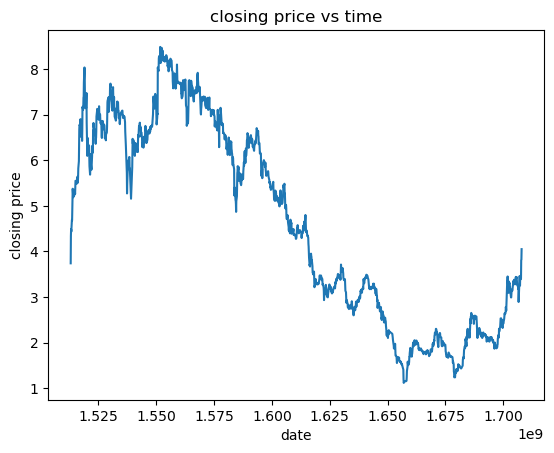

In [4]:
plt.plot(df['time'],df['close'])
plt.xlabel('date')
plt.ylabel('closing price')
plt.title('closing price vs time');

In [5]:
df.describe()

,time,open,high,low,close
count,1.503000e+03,1503.000000,1503.000000,1503.000000,1503.000000
mean,1.610694e+09,4.560761,4.651105,4.473829,4.561145
std,5.638538e+07,2.160621,2.191821,2.123005,2.160454
min,1.512979e+09,1.113000,1.150000,1.101000,1.113000
25%,1.562184e+09,2.500000,2.558584,2.440000,2.500000
50%,1.610870e+09,4.448593,4.517165,4.397165,4.448593
75%,1.659902e+09,6.605794,6.713992,6.464855,6.607626
max,1.707984e+09,8.489993,8.767191,8.341724,8.489993


#### wrangling function to make the data ready for training

In [6]:
def wrangling(df):
    df = df.sort_values(by='time') #sorting data by time
    df = df.set_index('time')
    df[['open_prev_snapshot','high_prev_snapshot','low_prev_snapshot']] = df[['open','high','low']].shift(1) #shifting rows to predict the coming price
    df = df.iloc[1:] #removing the first row 
    return df 


In [7]:
df = wrangling(df)

#### #Defining trainging features and target features


In [8]:
x = df[['open_prev_snapshot','high_prev_snapshot','low_prev_snapshot']]
y = df['close']

#### Initialize Scaler for normalization 


In [9]:
scaler = StandardScaler()

In [10]:
x_scaled = scaler.fit_transform(x)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

#### split data into train, validation and test and initialize model


In [11]:
x_train, x_temp, y_train, y_temp = train_test_split(x_scaled,y_scaled, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [12]:
model = ElasticNet()
model.fit(x_train,y_train)
y_pred = model.predict(x_val)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"MSE: {mse}, R2: {r2}")


MSE: 0.3342484668634826, R2: 0.6612563905375739


### We can enhance the performance using stacking technique with pass through option

###### Define a list of regressors


In [13]:
regressors = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
]
model_results = {}
for model in regressors:
    model_name = model.__class__.__name__
    try:
        model.fit(x_train, y_train)
        y_pred = model.predict(x_val)

        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        model_results[model_name] = {'MSE': mse, 'R2': r2}

        print(f"{model_name} - MSE: {mse:.4f}, R2: {r2:.4f}")

    except Exception as e:
        # Print the model name and the exception if it fails
        print(f"{model_name} - Error: {str(e)}")

LinearRegression - MSE: 0.0033, R2: 0.9967
Ridge - MSE: 0.0033, R2: 0.9967
Lasso - MSE: 0.9894, R2: -0.0027
ElasticNet - MSE: 0.3342, R2: 0.6613
DecisionTreeRegressor - MSE: 0.0054, R2: 0.9945
RandomForestRegressor - MSE: 0.0034, R2: 0.9966
GradientBoostingRegressor - MSE: 0.0035, R2: 0.9964


###### Apply stacking technique

In [14]:
level_0 = [
    ('rf', RandomForestRegressor()),
    ('gb', GradientBoostingRegressor()),
    ('dt', DecisionTreeRegressor()),
    ('rr', Ridge()),
    ('en', ElasticNet())
]

#Define meta-model
level_1 = GradientBoostingRegressor()

#Initialize StackingRegressor
stacking_regressor = StackingRegressor(estimators=level_0, final_estimator=level_1, passthrough=True)

#Train StackingRegressor
stacking_regressor.fit(x_train, y_train)

#Make predictions
train_predictions = stacking_regressor.predict(x_train)
val_predictions = stacking_regressor.predict(x_val)

#Evaluate performance based on explained variance score
train_explained_variance = explained_variance_score(y_train, train_predictions)
print("Training Score:", train_explained_variance)

val_explained_variance = explained_variance_score(y_val, val_predictions)
print("Validation Score:", val_explained_variance)


Training Score: 0.9978928372986419
Validation Score: 0.9965014159246508


##### make predictions

In [15]:
predictions = stacking_regressor.predict(x_scaled)
predictions

array([-0.25670613, -0.064396  , -0.03861636, ..., -0.52037451,
       -0.34719756, -0.25821844])

##### Denormalization and reseting index

In [16]:
prediction_inv = scaler.inverse_transform(predictions.reshape(-1, 1))
prediction_inv

array([[4.00711773],
       [4.42257491],
       [4.47826794],
       ...,
       [3.43750176],
       [3.81162456],
       [4.0038506 ]])

In [17]:
x = x.reset_index() 
y = y.reset_index()

##### calculate predicted and actual profit or loss

In [70]:
def calculate_cumulative_profit(x, prediction_inv, y):
    profits = []
    profits_act = []

    for i in range(len(prediction_inv)-1):
        buy_price_actual = x['open_prev_snapshot'].iloc[i+1]
        sell_price_predicted = prediction_inv[i]
        profit = sell_price_predicted - buy_price_actual
        profits.append(profit)

    for i in range(len(y)-1):
        buy_price_actual = x['open_prev_snapshot'].iloc[i+1]
        sell_price = y['close'][i]
        profit = sell_price - buy_price_actual
        profits_act.append(profit)

    profit_loss_cum = sum(profits)
    act_profit_loss_cum = sum(profits_act)

    return profit_loss_cum, act_profit_loss_cum

In [71]:
predicted_profit,actual_profit  = calculate_cumulative_profit(x, prediction_inv, y)
print("Predicted Profit/Loss:", predicted_profit)
print("Actual Profit/Loss:", actual_profit)

Predicted Profit/Loss: [0.70800912]
Actual Profit/Loss: 0.34716937999999953


Since the two outputs is positive then they are profits not losses,
Also since pridected profit is close to the actual profit then then the model is workin in good way!

#### Saving and loading the model

In [22]:
with open('stacking_regressor.pkl', 'wb') as f:
    pickle.dump(stacking_regressor,f)

In [23]:
with open('stacking_regressor.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

##### Testing model

In [24]:
test_predictions = loaded_model.predict(x_test)
test_explained_variance = explained_variance_score(y_test, test_predictions)
print("Testing Score:", test_explained_variance)

Testing Score: 0.9960456596198061


#### Applying the model to the remaining datasets 

##### EGX_DLY_EGX30 Dataset

In [109]:
test_df_1 = pd.read_csv(r"EGX_DLY_EGX30, 1D.csv")
test_df_1

,time,open,high,low,close
0,1256025600,7131.700195,7157.509766,7123.200195,7145.149902
1,1256112000,7139.060059,7139.290039,7062.069824,7062.089844
2,1256198400,7042.229980,7101.700195,7002.209961,7101.700195
3,1256457600,7133.209961,7207.540039,7131.310059,7188.750000
4,1256544000,7177.479980,7261.759766,7174.229980,7249.549805
...,...,...,...,...,...
3462,1707638400,28439.000000,28622.000000,27972.301000,28199.000000
3463,1707724800,28327.900000,28690.500000,27681.199000,28494.699000
3464,1707811200,28545.500000,28839.400000,28306.600000,28604.500000
3465,1707897600,28633.699000,28973.400000,28601.500000,28875.000000


In [110]:
test_df_1 = wrangling(test_df_1)
test_df_1

,open,high,low,close,open_prev_snapshot,high_prev_snapshot,low_prev_snapshot
time,,,,,,,
1256112000,7139.060059,7139.290039,7062.069824,7062.089844,7131.700195,7157.509766,7123.200195
1256198400,7042.229980,7101.700195,7002.209961,7101.700195,7139.060059,7139.290039,7062.069824
1256457600,7133.209961,7207.540039,7131.310059,7188.750000,7042.229980,7101.700195,7002.209961
1256544000,7177.479980,7261.759766,7174.229980,7249.549805,7133.209961,7207.540039,7131.310059
1256630400,7240.009766,7240.470215,7189.750000,7198.160156,7177.479980,7261.759766,7174.229980
...,...,...,...,...,...,...,...
1707638400,28439.000000,28622.000000,27972.301000,28199.000000,28041.301000,28422.801000,27864.301000
1707724800,28327.900000,28690.500000,27681.199000,28494.699000,28439.000000,28622.000000,27972.301000
1707811200,28545.500000,28839.400000,28306.600000,28604.500000,28327.900000,28690.500000,27681.199000


In [111]:
x_1 = test_df_1[['open_prev_snapshot','high_prev_snapshot','low_prev_snapshot']]
y_1= test_df_1['close']

In [113]:
#Fit and transform the data
x_scaled_1 = scaler.fit_transform(x_1)
y_scaled_1 = scaler.fit_transform(y_1.values.reshape(-1, 1))

In [114]:
test_1_preds = loaded_model.predict(x_scaled_1)
test_1_explained_variance = explained_variance_score(y_scaled_1, test_1_preds)
print("Testing Score:", test_1_explained_variance)

Testing Score: 0.9293082856263143


##### EGX_DLY_EMFD Dataset

In [80]:
test_df_2 = pd.read_csv(r"EGX_DLY_EMFD, 1D.csv")
test_df_2

,time,open,high,low,close
0,1425542400,1.00,1.00,1.00,1.00
1,1425801600,1.00,1.00,1.00,1.00
2,1425888000,1.00,1.00,1.00,1.00
3,1425974400,1.00,1.00,1.00,1.00
4,1426060800,1.00,1.00,1.00,1.00
...,...,...,...,...,...
2136,1707638400,5.89,6.35,5.85,6.03
2137,1707724800,6.03,6.87,5.90,6.69
2138,1707811200,6.69,6.89,6.50,6.62
2139,1707897600,6.62,6.69,6.42,6.55


In [81]:
test_df_2= wrangling(test_df_2)
test_df_2

,open,high,low,close,open_prev_snapshot,high_prev_snapshot,low_prev_snapshot
time,,,,,,,
1425801600,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1425888000,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1425974400,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1426060800,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1426147200,1.00,1.00,1.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...
1707638400,5.89,6.35,5.85,6.03,6.05,6.16,5.85
1707724800,6.03,6.87,5.90,6.69,5.89,6.35,5.85
1707811200,6.69,6.89,6.50,6.62,6.03,6.87,5.90


In [82]:
x_2 = test_df_2[['open_prev_snapshot','high_prev_snapshot','low_prev_snapshot']]
y_2= test_df_2['close']

In [83]:
#Fit and transform the data
x_scaled_2 = scaler.fit_transform(x_2)
y_scaled_2= scaler.fit_transform(y_2.values.reshape(-1, 1))

In [84]:
test_2_preds = loaded_model.predict(x_scaled_2)
test_2_explained_variance = explained_variance_score(y_scaled_2, test_2_preds)
print("Testing Score:", test_2_explained_variance)

Testing Score: 0.8858435080353748


##### EGX_DLY_EMFD Dataset

In [117]:
test_df_3 = pd.read_csv(r"EGX_DLY_COMI, 1D.csv")
test_df_3

,time,open,high,low,close
0,989910000,0.839019,0.839019,0.827202,0.831220
1,989996400,0.827202,0.836419,0.823184,0.826020
2,990082800,0.827202,0.827202,0.820111,0.824366
3,990342000,0.815621,0.821293,0.815385,0.816566
4,990428400,0.813257,0.850836,0.809476,0.831456
...,...,...,...,...,...
5524,1707638400,80.489998,80.500000,78.019997,79.550003
5525,1707724800,79.550003,84.500000,78.750000,83.120003
5526,1707811200,83.120003,83.120003,80.019997,81.059998
5527,1707897600,81.059998,82.400002,80.529999,81.989998


In [118]:
test_df_3= wrangling(test_df_3)
test_df_3

,open,high,low,close,open_prev_snapshot,high_prev_snapshot,low_prev_snapshot
time,,,,,,,
989996400,0.827202,0.836419,0.823184,0.826020,0.839019,0.839019,0.827202
990082800,0.827202,0.827202,0.820111,0.824366,0.827202,0.836419,0.823184
990342000,0.815621,0.821293,0.815385,0.816566,0.827202,0.827202,0.820111
990428400,0.813257,0.850836,0.809476,0.831456,0.815621,0.821293,0.815385
990514800,0.827202,0.832874,0.827202,0.829329,0.813257,0.850836,0.809476
...,...,...,...,...,...,...,...
1707638400,80.489998,80.500000,78.019997,79.550003,77.599998,81.250000,77.599998
1707724800,79.550003,84.500000,78.750000,83.120003,80.489998,80.500000,78.019997
1707811200,83.120003,83.120003,80.019997,81.059998,79.550003,84.500000,78.750000


In [119]:
x_3= test_df_3[['open_prev_snapshot','high_prev_snapshot','low_prev_snapshot']]
y_3= test_df_3['close']

In [120]:
#Fit and transform the data
x_scaled_3= scaler.fit_transform(x_3)
y_scaled_3= scaler.fit_transform(y_3.values.reshape(-1, 1))

In [121]:
test_3_preds = loaded_model.predict(x_scaled_3)
test_3_explained_variance = explained_variance_score(y_scaled_3, test_3_preds)
print("Testing Score:", test_3_explained_variance)

Testing Score: 0.932051461489452
